# Литература
[Practitioner’s Guide to Statistical Tests](https://vkteam.medium.com/practitioners-guide-to-statistical-tests-ed2d580ef04f#d2d3)

[А/Б тесты с метрикой отношения. Дельта-метод](https://habr.com/ru/companies/X5Tech/articles/740476/)

[A/B-тесты с метриками-отношениями и при чём здесь внутрипользовательские корреляции](https://www.youtube.com/watch?v=ObzlKVCiBqI&list=PLAynZk3jFRd_81lZ1W0E9XEyXtAljkBlh&index=7&t=5201s)

In [33]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

In [35]:
sns.set_theme(context='notebook', 
                  style='darkgrid', 
                  palette='deep',
                  font='sans-serif', 
                  font_scale=1, 
                  color_codes=True, 
                  rc=None)

# Генерация данных

In [101]:
def get_session_duration(size, effect=0, seed=None):

    def _user_sessions(mean):
        size = np.random.randint(3, 10)
        duration = np.random.normal(loc=mean, scale=10, size=size).round()
        duration = np.where(duration > 0, duration, 0)
        return duration
    
    if seed:
        np.random.seed(seed)
    
    mean_durations = np.random.normal(loc=100, scale=20, size=size) * (1 + effect)
    
    return [_user_sessions(mean) for mean in mean_durations]

In [115]:
list_session_mean = []
list_user_avg_mean = []

def get_naive_mean_delta(a, b):
    return np.concatenate(b).mean() - np.concatenate(a).mean()

def get_user_avg_mean_delta(a, b):
    return np.mean([t.mean() for t in b]) - np.mean([t.mean() for t in a])

for _ in tqdm(range(1000)):
    a = get_session_duration(100)
    b = get_session_duration(100)
    list_session_mean.append(get_naive_mean_delta(a, b))
    list_user_avg_mean.append(get_user_avg_mean_delta(a, b))
    
df = pd.DataFrame({'list_session_mean': list_session_mean,
                   'list_user_avg_mean': list_user_avg_mean
                  })
df['sign'] = (df['list_session_mean'] * df['list_user_avg_mean']) >= 0

  0%|          | 0/1000 [00:00<?, ?it/s]

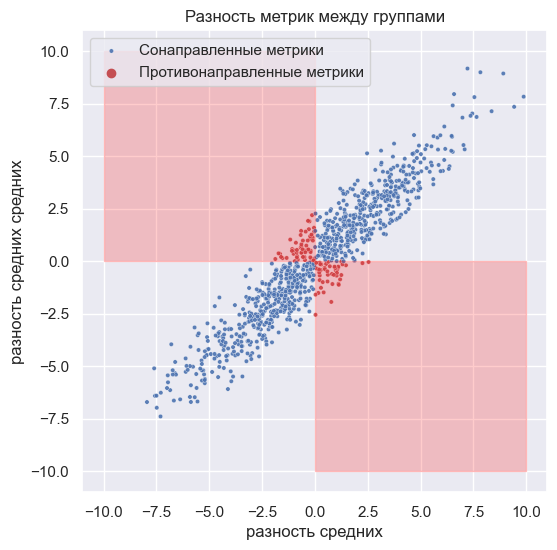

In [119]:
plt.figure(figsize=(6, 6))
sns.scatterplot(data=df,
                x=df.list_session_mean, 
                y=df.list_user_avg_mean, 
                hue = 'sign', 
                s=10, 
                alpha=0.9, 
                palette=['r', 'b'])

plt.fill_between([-10, -10, 0, 0, 0, 0, 10, 10], [0, 10, 10, 0, 0, -10, -10, 0], color='red', alpha=0.2)
plt.legend(['Сонаправленные метрики', 'Противонаправленные метрики'])

plt.ylabel('разность средних пользовательских средних')
plt.xlabel('разность средних')
plt.title('Разность метрик между группами')
plt.show()